In [1]:
ModelToLoad = 13

In [ ]:
### Memory commands

print(torch.cuda.memory_allocated()/1024**3)
print(torch.cuda.memory_cached()/1024**3)
torch.cuda.empty_cache()

# x = torch.randn(1024**3, device='cuda')
# device='cuda:0'
# x = x.cuda()
# del y
# print(x.dtype)
# print('OnGPUMemory:', x.element_size()*x.nelement()/1024**3, 'GB')

# torch.cuda.memory_allocated()
# torch.cuda.max_memory_allocated()/1024**3
# torch.cuda.memory_reserved()
# torch.cuda.max_memory_reserved()/1024**3
# torch.cuda.empty_cache()
# torch.cuda.memory_stats()
# torch.cuda.memory_snapshot()

# torch.cuda.get_device_properties(device)
# torch.cuda.memory_usage()
# torch.cuda.list_gpu_processes() ####################################################
# print(torch.cuda.memory_summary()) #######################################

In [2]:
# Imports, class definitions
# print("Importing ...")

import torch
import torch.nn as nn
import torch.optim as optim
from   torch.utils.data import DataLoader
import torchvision.transforms as transforms # Using TorchIO may help in 3D augmentation *
import nibabel as nib
import numpy as np
import random

import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import time

# Define your model architecture here
# print("Defining Classes ...")

# Class UNet3D
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels , out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool3d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module): #
    def __init__(self, in_channels, out_channels, bilinear=True):
        super(Up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels)
        else:
            self.up = nn.ConvTranspose3d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffZ = x2.size()[2] - x1.size()[2] # NCXYZ
        diffY = x2.size()[3] - x1.size()[3]
        diffX = x2.size()[4] - x1.size()[4]
        x1 = nn.functional.pad(x1, (diffX // 2, diffX - diffX // 2,
                                    diffY // 2, diffY - diffY // 2,
                                    diffZ // 2, diffZ - diffZ // 2))
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet3D(nn.Module): ### Add dropout!
    def __init__(self, in_channels, out_channels):
        super(UNet3D, self).__init__()
        self.inc = DoubleConv(in_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256)
        self.up2 = Up(512, 128)
        self.up3 = Up(256, 64)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, out_channels)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        output = self.outc(x)
        return output

# Define a custom transform class for applying the same random crop
class RandomCrop3D: ###
    def __init__(self, output_size):
        self.output_size = output_size

    def __call__(self, sample):
        inputs, targets = sample

        # Get the input size
        input_size = inputs.shape[2:] ###

        # Calculate the starting index for the crop
        start_indexes = [random.randint(0, input_size[i] - self.output_size[i]) for i in range(3)]

        # Perform the crop on both inputs and targets
        inputs  = inputs [:,:, start_indexes[0]:start_indexes[0] + self.output_size[0], 
                               start_indexes[1]:start_indexes[1] + self.output_size[1],
                               start_indexes[2]:start_indexes[2] + self.output_size[2]]

        targets = targets[:,:, start_indexes[0]:start_indexes[0] + self.output_size[0], 
                               start_indexes[1]:start_indexes[1] + self.output_size[1],
                               start_indexes[2]:start_indexes[2] + self.output_size[2]]

        return inputs, targets

# Define the output size for random cropping
output_size = (128, 128, 128)

# Define the transforms
transform = transforms.Compose([
    RandomCrop3D(output_size),              # Custom random crop
    # transforms.RandomVerticalFlip(),        # Random vertical flipping
    # transforms.RandomHorizontalFlip()        # Random horizontal flipping
])

# Define your dataset class for loading CT images and masks

class CTImageDataset(torch.utils.data.Dataset): ### Yields with 1 channel dim [No batch dim yet]
    def __init__(self, image_paths, mask_paths):
        self.image_paths = image_paths
        self.mask_paths  = mask_paths

    def __getitem__(self, index):
        image = nib.load(self.image_paths[index]).get_fdata()
        mask  = nib.load(self.mask_paths [index]).get_fdata()
        image = torch.from_numpy(image).unsqueeze(0).float() ### 1-Channel?!
        mask  = torch.from_numpy(mask ).unsqueeze(0).long() ### Changed!
        return image, mask

    def __len__(self):
        return len(self.image_paths)

In [3]:
# Training function definition

def train(model, train_loader, criterion, optimizer, device): ###
    model.train() ###
    running_loss = 0.0

    for batch_idx, (images, masks) in enumerate(train_loader):
        # print(f"Batch {batch_idx+1} Started")

        images = images.to(device)
        masks  = masks .to(device)

        # Apply transforms to the inputs and targets
        images, masks = transform((images, masks))

        optimizer.zero_grad()

        # Forward pass
        # print("Passing through Model ...")
        outputs = model(images)

        # Compute loss
        # print("CrossEnthropy() ...")
        loss = criterion(outputs, torch.squeeze(masks, dim=1)) #####################################

        # Backward pass and optimization
        # print("Backward ...")
        loss.backward()
        # print("Step ...")
        optimizer.step()




        # Should I detach() the output?!




        running_loss += loss.item()

    return running_loss / len(train_loader), images[0,0].cpu(), masks[0,0].cpu(), outputs[0].detach().cpu()

In [4]:
# Training parameters: device, epochs, lr, ..
# print("Setting Parameters & Instanciating ...")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") ####1
epochs = 4
batch_size = 1 #4 ###
learning_rate = 0.0003 #0.0001 ###

In [5]:
# Create a new model instance & load M-Model-N

model = UNet3D(in_channels=1, out_channels=3)
model = model.to(device)
# GMem+=0.4GB > 3.1GB [>1.5GB]
model.load_state_dict(torch.load("./Models/M-Model-"+f'{ModelToLoad:02.0f}'+".pth")) ########################## m1
# GMem+=0.6GB > 3.7GB

<All keys matched successfully>

In [ ]:
### Count the number of trainable parameters
num_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_parameters}")
# Number of trainable parameters: 40158723

# Model size
print("Model size assuming float32bit weights:", 40158723*32/8/1024**2, "MB")

# print(model)

In [ ]:
### Parameters table
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Mod name", "Parameters Listed"])
    t_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        t_params+=param
    print(table)
    print(f"Sum of trained paramters: {t_params}")
    return t_params

count_parameters(model)

In [6]:
# Image paths, criterion/optimizer

# Create your dataset and data loader instances
import os
IDS = [36, 43, 54]
image_paths = [os.path.join('Data','SPIROMCS-Case'+str(ID)+'-Vx3.nii.gz') for ID in IDS]
mask_paths  = [os.path.join('Data','SPIROMCS-Case'+str(ID)+'-012Labelmap.nii.gz') for ID in IDS]

train_dataset = CTImageDataset(image_paths[0:2], mask_paths[0:2]) ### Cases 36,43
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=False) ### Mask: B=1?C=1?XYZ? #shuffle=True

valid_dataset = CTImageDataset( [ image_paths[2] ] , [ mask_paths[2] ] ) ### Cases 54
valid_loader  = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False) ### Adds Batch dim  ## Mask: B=1?C=1?XYZ? #shuffle=True

# Define your loss function and optimizer

weight = torch.tensor([1,10,10], dtype=torch.float, device=device)
criterion = nn.CrossEntropyLoss(weight=weight) ####2 ignore_index (int, optional) *** #### Using max of all N losses?!!!!
optimizer = optim.Adam(model.parameters(), lr=learning_rate) ###

In [13]:
IDS = [36, 43, 54]

image = nib.load(image_paths[0]).get_fdata()
mask  = nib.load(mask_paths [0]).get_fdata()
image = torch.from_numpy(image).unsqueeze(0).float() ### 1-Channel?!
mask  = torch.from_numpy(mask ).unsqueeze(0).long() ### Changed!

In [ ]:
### ToDo: Get label distribution for calss weights
# Here!
# np.array([1,10,10])/21

In [12]:
# Desc; Read file and create train_losses, unqlabels, unqlabelindices

desc = 'Using-' + f'{ModelToLoad:02.0f}' + '|LR=' + str(learning_rate) + '|x' + str(epochs)
PlotOnlyTheLastNLabels = 6

# LastIteration, train_loss, labels

train_losses, valid_losses, labels  = [],[],[] #>>

with open('D-LossValues.txt', 'r') as file:
    for line in file:
        parts = line.strip().split(", ")
        train_losses.append(float(parts[1]))
        valid_losses.append(float(parts[2]))
        labels.append(parts[3])
        LastIteration = int(parts[0])

# unqlabels, unqlabelindices, howmanyinfile

unqlabels = [] #>>
unqlabelindices = [] #>>
currentlabel = []

for indx,lab in enumerate(labels):
    if lab != currentlabel:
        unqlabelindices.append(indx)
        unqlabels.append(lab)
        currentlabel = lab

howmanyinfile = len(train_losses) # Used only once to append to unqlabelindices

# Trimming unqlabelindices, unqlabels, train_losses; appending last index; shifting down

LOCINDX = -PlotOnlyTheLastNLabels+1  # From LOCINDX to the end of all lists

unqlabelindices = unqlabelindices[LOCINDX:] # Pick desired labels
unqlabels = unqlabels[LOCINDX:] # Pick desired labels
STARTIND = unqlabelindices[LOCINDX] # Start index [0-] in terms of full train_losses list in file

train_losses = train_losses[STARTIND:] # Pick desired part
valid_losses = valid_losses[STARTIND:] # Pick desired part

if unqlabels[-1] == desc: desc += '-' # So consecutive experiments with same settings have different labels

unqlabels.append(desc) # Include the label of new experiment
unqlabelindices.append(howmanyinfile) # Point to where the above label is

unqlabelindices = [ind-STARTIND for ind in unqlabelindices] # After trimming, all indices should be shifted

In [ ]:
### Correct the Loss file: ONLY ONCE!
# Open the input file for reading
with open("D-Lossvalues.b", "r") as input_file:
    # Read the lines from the input file
    lines = input_file.readlines()

# Process the lines from 1 to 87
processed_lines = []
for line in lines[:87]:
    parts = line.strip().split(", ")
    if len(parts) == 3:
        new_line = f"{parts[0]}, {float(parts[1]):020.15f}, {float(parts[1]):020.15f}, {parts[2]}"
        processed_lines.append(new_line)

# Process the lines from 88 till the end
for line in lines[87:]:
    parts = line.strip().split(", ")
    if len(parts) == 4:
        new_line = f"{parts[0]}, {float(parts[1]):020.15f}, {float(parts[3]):020.15f}, {parts[2]}"
        processed_lines.append(new_line)

# Write the processed lines to the output file
with open("D-LossValues.txt", "w") as output_file:
    output_file.write("\n".join(processed_lines))

In [13]:
# Validation function definition

def valid(model, valid_loader, criterion, device):
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for batch_idx, (images, masks) in enumerate(valid_loader): # 1 batch, 1 channel, 3 spatial dims

            images = images.to(device)
            masks  = masks .to(device)

            # images, masks = transform((images, masks))
            # images = images[:,:,200:300,200:300,200:300]
            # masks  = masks [:,:,200:300,200:300,200:300]

            size3d  = [180, 180, 180]
            strtind = [150, 150, 150]

            images = images[:,:,strtind[0]:strtind[0]+size3d[0],strtind[1]:strtind[1]+size3d[1],strtind[2]:strtind[2]+size3d[2]]
            masks  = masks [:,:,strtind[0]:strtind[0]+size3d[0],strtind[1]:strtind[1]+size3d[1],strtind[2]:strtind[2]+size3d[2]]

            outputs = model(images) # outputs.size() = torch.Size([1, 3, 180, 180, 180])

            loss = criterion(outputs, torch.squeeze(masks, dim=1))

            running_loss += loss.item()

        return running_loss / len(valid_loader), images[0,0].cpu(), masks[0,0].cpu(), outputs[0].cpu()

In [ ]:
### itkwidgets testing
# ba = torch.FloatTensor(2, 2, 5, 5, 5)
# ba[:,:,2:4,2:4,2:4]

# Plotting the SameCrop()

for batch_idx, (images, masks) in enumerate(valid_loader): # 1 batch, 1 channel, 3 spatial dims

    # images = images.to(device)
    # masks  = masks .to(device)

    size3d  = [180, 180, 180]
    strtind = [150, 150, 150]

    # images, masks = transform((images, masks))
    # images = images[:,:,200:300,200:300,200:300]
    # masks  = masks [:,:,200:300,200:300,200:300]
    images = images[:,:,strtind[0]:strtind[0]+size3d[0],strtind[1]:strtind[1]+size3d[1],strtind[2]:strtind[2]+size3d[2]]
    masks  = masks [:,:,strtind[0]:strtind[0]+size3d[0],strtind[1]:strtind[1]+size3d[1],strtind[2]:strtind[2]+size3d[2]]
   

print(images.shape)

# pip install itk itkwidgets
# import itk
# import itkwidgets

# Assuming you have a 3D image named 'image'
# image = itk.imread('.\Data\SPIROMCS-Case54-Vx3.nii.gz')  # Replace with the path to your actual 3D image file
# label = itk.imread('.\Data\SPIROMCS-Case54-012Labelmap.nii.gz')  # Replace with the path to your actual 3D image file

# Display the 3D image using itkwidgets
itkwidgets.view(images[0,0].cpu(), label_image = masks[0,0].cpu()) # , label_image=label

In [ ]:
# import itk
# import itkwidgets

# Display the 3D image using itkwidgets
itkwidgets.view(images[0,0].cpu(), label_image = masks[0,0].cpu()) # , label_image=label
# itkwidgets.view?
# mode= 'x'
# label_image_weights=
# size_limit_3d= 3x1 numpy int64 array, default: [192, 192, 192]

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


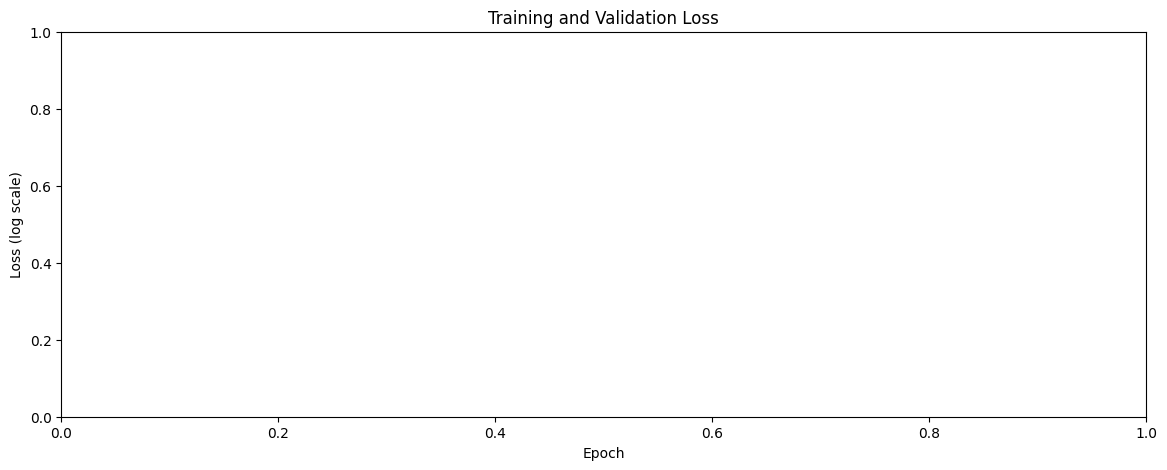

training loop ...


FileNotFoundError: No such file or no access: 'Data\SPIROMCS-Case36-Vx3.nii.gz'

In [15]:
# Start the training loop, create losses list, save the model

mode = ['0-Real', '1-Quick']
mode = mode[0]

import itkwidgets
import ipywidgets as widgets
from IPython.display import clear_output, display
import time
import numpy as np

clear_output(wait=True)

fig, ax = plt.subplots(figsize=(14, 5))
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss (log scale)')
ax.set_title('Training and Validation Loss')
colormap = plt.cm.get_cmap('rainbow')
plt.show()

tab = widgets.Tab()
viewer = []

def update_plot(epoch, train_loss, valid_loss, viewer):
    
    train_losses.append(train_loss) # Append newly generated value
    valid_losses.append(valid_loss) # Append newly generated value
    clear_output(wait=True)

    xx = range(1, len(train_losses)+2) # Add one dummy value at the end for plot continuity purposes
    labinds = unqlabelindices + [len(train_losses)] # Add pointer to the updating final index available for plotting

    tt = train_losses + [train_losses[-1]] # Add one dummy value at the end for plot continuity purposes
    vv = valid_losses + [valid_losses[-1]] # Add one dummy value at the end for plot continuity purposes

    for i, label in enumerate(unqlabels):
        POE = int(i != len(unqlabels)-1) #PlotOneExtraForPreviousLabels: Deactivates for the latest label
        ax.plot(xx[labinds[i]:labinds[i+1]+POE], tt[labinds[i]:labinds[i+1]+POE],
                'o-', label=label, color=colormap(i/len(unqlabels)))
        ax.plot(xx[labinds[i]:labinds[i+1]+POE], vv[labinds[i]:labinds[i+1]+POE],
                'o-', color=(0.8, 0.8, 0.8))
    
    ax.set_yscale('log')
    ax.relim()
    ax.autoscale_view()
    if epoch == 0: ax.legend(fontsize='x-small')
    clear_output(wait=True)
    display(fig)



    # fig2 = plt.figure()

    # Add the viewers to separate tabs
    tab.children = [vw for vw in viewer]
    for i, _ in enumerate(viewer):
        tab.set_title(i, 'Valid-'+str(i//2) if i%2 else 'Train-'+str(i//2))
    
    # Display the tabbed interface

    display(tab)
    # print("Waiting 2 seconds ...")
    # time.sleep(2)

    

# Open the file in append mode # GMem=3GB
with open('D-LossValues.txt', 'a') as file:
    for epoch in range(epochs):
        
        # Training loop
        print('training loop ...')
        if mode == '0-Real':
            train_loss, viewtrnimages, viewtrnmasks, viewtrnoutput = train(
                model, train_loader, criterion, optimizer, device) ########
        elif mode == '1-Quick':
            NNN = output_size[0] # 40
            viewtrnimages = torch.rand(NNN, NNN, NNN)
            viewtrnmasks  = torch.randint(0, high=3, size=(NNN, NNN, NNN))

            viewtrnoutput = torch.zeros((3, NNN, NNN, NNN))
            viewtrnoutput[1,   NNN//3:,   NNN//3:,   NNN//3:] = 1
            viewtrnoutput[2, 2*NNN//3:, 2*NNN//3:, 2*NNN//3:] = 2

            train_loss = 0.8 #epoch-1
        
        # Validation loop
        print('validation loop ...')
        if mode == '0-Real':
            valid_loss, viewvalimages, viewvalmasks, viewvaloutput = valid(
                model, valid_loader, criterion, device)
        elif mode == '1-Quick':
            viewvalimages = torch.rand(NNN, NNN, NNN) + 2
            viewvalmasks  = torch.randint(0, high=3, size=(NNN, NNN, NNN))

            viewvaloutput = torch.zeros((3, NNN, NNN, NNN))
            viewvaloutput[1,   NNN//4:,   NNN//4:,   NNN//4:] = 1
            viewvaloutput[2, 2*NNN//4:, 2*NNN//4:, 2*NNN//4:] = 2

            valid_loss = 1.0 #epoch-1
        
        # Convert to class labels (assuming CrossEntropyLoss was used)
        viewtrnoutput = torch.argmax(viewtrnoutput, dim=0)
        viewvaloutput = torch.argmax(viewvaloutput, dim=0)

        # Create itkwidgets viewer for each image
        if epoch==0:
            # viewer.append(itkwidgets.view(viewtrnimages, label_image = viewtrnmasks ))
            viewer.append(itkwidgets.view(viewtrnimages, label_image = viewtrnoutput))
            # viewer.append(itkwidgets.view(viewvalimages, label_image = viewvalmasks ))
            viewer.append(itkwidgets.view(viewvalimages, label_image = viewvaloutput))
        if epoch==1:
            # viewer.append(itkwidgets.view(viewtrnimages, label_image = viewtrnmasks ))
            viewer.append(itkwidgets.view(viewtrnimages, label_image = viewtrnoutput))
            # viewer.append(itkwidgets.view(viewvalimages, label_image = viewvalmasks ))
            viewer.append(itkwidgets.view(viewvalimages, label_image = viewvaloutput))
        # if epoch==2:
        #     # viewer.append(itkwidgets.view(viewtrnimages, label_image = viewtrnmasks ))
        #     viewer.append(itkwidgets.view(viewtrnimages, label_image = viewtrnoutput))
        #     # viewer.append(itkwidgets.view(viewvalimages, label_image = viewvalmasks ))
        #     viewer.append(itkwidgets.view(viewvalimages, label_image = viewvaloutput))
        # if epoch==3:
        #     # viewer.append(itkwidgets.view(viewtrnimages, label_image = viewtrnmasks ))
        #     viewer.append(itkwidgets.view(viewtrnimages, label_image = viewtrnoutput))
        #     # viewer.append(itkwidgets.view(viewvalimages, label_image = viewvalmasks ))
        #     viewer.append(itkwidgets.view(viewvalimages, label_image = viewvaloutput))
        # if i==2: viewer.append(itkwidgets.view(viewtrnimages, label_image = viewtrnmasks ))
        # if i==3: viewer.append(itkwidgets.view(viewtrnimages, label_image = viewtrnoutput))

        # Update the plot
        update_plot(epoch, train_loss, valid_loss, viewer)

        # Append loss values to file, use custom label, write each number on a new line
        if mode == '0-Real':
            file.write(f'{LastIteration+epoch+1:07.0f}, ' + f'{train_loss:020.15f}, ' +
                   f'{valid_loss:020.15f}, ' + desc + '\n')

        if mode == '1-Quick':
            print("Waiting 15 seconds ...")
            time.sleep(15)



        #### add time/date too! **



        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")

# Close the plot after the loop finishes
plt.close(fig)

# Save the trained model
if mode == '0-Real':
    torch.save(model.state_dict(), "./Models/M-Model-"+f'{ModelToLoad+1:02.0f}'+".pth") ################### m2





#### Save as new model, don't overwrite!





# GMem=18.7GB-19.4GB

In [ ]:
### 4 Tabs working fine without for loop
import itkwidgets
import ipywidgets as widgets

# Convert to class labels (assuming CrossEntropyLoss was used)
viewvaloutput = torch.argmax(viewvaloutput, dim=0)
viewtrnoutput = torch.argmax(viewtrnoutput, dim=0)

# Create itkwidgets viewer for each image
viewer1 = itkwidgets.view(viewvalimages, label_image = viewvalmasks )
viewer2 = itkwidgets.view(viewvalimages, label_image = viewvaloutput)
viewer3 = itkwidgets.view(viewtrnimages, label_image = viewtrnmasks )
viewer4 = itkwidgets.view(viewtrnimages, label_image = viewtrnoutput)

# Create tabs and add the viewers to separate tabs
tab = widgets.Tab()
tab.children = [viewer1, viewer2, viewer3, viewer4]
tab.set_title(0, 'Image 1')
tab.set_title(1, 'Image 2')
tab.set_title(2, 'Image 3')
tab.set_title(3, 'Image 4')

# Display the tabbed interface
display(tab)


# itkwidgets.view(viewvalimages, label_image = viewvalmasks) # , label_image=label

# mode= 'y',
# label_image_blend=0.5,
# vmin: list of floats, default: Minimum of the image pixel buffer
# interpolation: bool, default: True
# size_limit_3d: 3x1 numpy int64 array, default: [192, 192, 192]
# sample_distance: float, default: 0.25
#     Sampling distance for volume rendering, normalized from 0.0 to 1.0.

# itkwidgets.view(viewvalimages, label_image = viewvaloutput) # , label_image=label
# viewvaloutput

In [ ]:
### Toy example to fully understand the view behavior

import itkwidgets
import ipywidgets as widgets
from IPython.display import clear_output, display
import time
import numpy as np

NNN = 200
viewvalimages = np.random.rand(NNN, NNN, NNN)
viewtrnimages = np.random.rand(NNN, NNN, NNN)
viewbdsimages = np.random.rand(NNN, NNN, NNN)
# viewvalimages = np.zeros((NNN, NNN, NNN))
# viewtrnimages = np.zeros((NNN, NNN, NNN))
# viewbdsimages = np.zeros((NNN, NNN, NNN))

print("Into the for loop ...")
for i in range(NNN):
    for j in range(NNN):
        for k in range(NNN):
            viewvalimages[i, j, k] = max(i, j, k)
print("Out of the for loop ...")

clear_output(wait=True)

tab = widgets.Tab()
viewer = []

for i in range(3):

    # Create itkwidgets viewer for each image
    if i==0: viewer.append(itkwidgets.view(viewvalimages))
    if i==1: viewer.append(itkwidgets.view(viewtrnimages))
    if i==2: viewer.append(itkwidgets.view(viewbdsimages))
    # label_image = np.random.randint(0, high=3, size=(NNN, NNN, NNN))

    # if i==0: viewer.append(itkwidgets.view(viewvalimages, label_image = viewvalmasks ))
    # if i==1: viewer.append(itkwidgets.view(viewvalimages, label_image = viewvaloutput))
    # viewer3 = itkwidgets.view(viewtrnimages, label_image = viewtrnmasks )
    # viewer4 = itkwidgets.view(viewtrnimages, label_image = viewtrnoutput)

    # Create tabs and add the viewers to separate tabs

    tab.children = [vw for vw in viewer]
    # tab.set_title(0, 'Image 1')
    # tab.set_title(1, 'Image 2')
    # tab.set_title(2, 'Image 3')
    # tab.set_title(3, 'Image 4')

    # Display the tabbed interface
    clear_output(wait=True)
    display(tab)
    print("Waiting 2 seconds ...")
    time.sleep(2)

# plt.close(fig)

In [88]:
### itkwidgets.view?

Signature:
itkwidgets.view(
    image=None,
    label_image=None,
    label_image_names=None,
    label_image_weights=None,
    label_image_blend=0.5,
    cmap=None,
    lut='glasbey',
    select_roi=False,
    interpolation=True,
    gradient_opacity=0.22,
    opacity_gaussians=None,
    channels=None,
    slicing_planes=False,
    shadow=True,
    blend_mode='composite',
    point_sets=None,
    point_set_colors=None,
    point_set_opacities=None,
    point_set_representations=None,
    point_set_sizes=None,
    geometries=None,
    geometry_colors=None,
    geometry_opacities=None,
    ui_collapsed=False,
    rotate=False,
    annotations=True,
    axes=False,
    mode='v',
    **kwargs,
)
Docstring:
View the image and/or point sets and/or geometries.

Creates and returns an ipywidget to visualize an image, and/or point sets
and/or geometries .

The image can be 2D or 3D. A label map that corresponds to the image can
also be provided. The image and label map must have the same size.

In [25]:
### Some string tests
# A = f'{ABCD:020.15f}'
# B = f'{LastIteration+epoch+1:07.0f}, ' + f'{train_loss:015.10f}, ' + f'{valid_loss:015.10f}, ' + desc + '\n'
# A
# # {:<15.10f}
# # with open('D-ABC.txt', 'a') as file:
# #     file.write(A)

'0000.234353847565849'

In [49]:
# Infer step #1
# Load the trained model
# model.load_state_dict(torch.load("model-03.pth"))
model.eval()

# Load and preprocess the input image

image = nib.load("Data\SPIROMCS-Case54-Vx3.nii.gz").get_fdata()
mask  = nib.load("Data\SPIROMCS-Case54-012Labelmap.nii.gz").get_fdata()

image = torch.from_numpy(image).unsqueeze(0).float() ### Channels=1 !
mask  = torch.from_numpy(mask ).unsqueeze(0).long()  ### Changed!

input_tensor = image.unsqueeze(0).to(device)  # Add batch dimension
mask_tensor  = mask .unsqueeze(0).to(device)  # Add batch dimension ############## to(device) after tramsform!

input_tensor, mask_tensor = transform((input_tensor, mask_tensor))

# Perform inference
with torch.no_grad():
    output_tensor = model(input_tensor)

# Post-process the output tensor
output_tensor = torch.argmax(output_tensor, dim=1)  # Convert to class labels (assuming CrossEntropyLoss was used)

In [50]:
# Save infer artifacts x3 to disk

output_array = output_tensor.squeeze(0).cpu().numpy().astype('int16')
img = nib.Nifti1Image(output_array, np.eye(4))
nib.save(img, "./Data/36-OutputArray.nii.gz")

mask_array = mask_tensor.squeeze(dim=(0,1)).cpu().numpy().astype('int16')
img = nib.Nifti1Image(mask_array, np.eye(4))
nib.save(img, "./Data/36-MaskArray.nii.gz")

input_array = input_tensor.squeeze(dim=(0,1)).cpu().numpy().astype('int16')
img = nib.Nifti1Image(input_array, np.eye(4))
nib.save(img, "./Data/36-CroppedImage.nii.gz")

In [ ]:
# Some bells & whistles for validation loop
import time

# define an empty list called validation_loss that might be helpful later in the early stopping implementation
validation_loss = []

start_time = time.time()
best_loss = np.float('inf')

for epoch in range(10):  # loop over the dataset multiple times
    # Validation
    #------------
    with torch.no_grad(): 
      running_loss = 0.0
      for i, data in enumerate(validloader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data[0].to(device), data[1].to(device)

          # forward 
          outputs = net(inputs)
          loss = criterion(outputs, labels)

          # print statistics
          running_loss += loss.item()
      epoch_loss = running_loss / (i+1)

      # add epoch_loss at each iteration to the validation_loss list which is later used in the early stopping implementation
      validation_loss.append(epoch_loss)

      print("Epoch: ", epoch, " validation loss: ", '%.3f' % epoch_loss)
      # save the best model based on validation loss
      if epoch_loss < best_loss:
        # torch.save(net.state_dict(), PATH)
        best_loss = epoch_loss

      # Early stopping implementation goes below: (TODO)

time_elap = (time.time() - start_time) // 60
print('Finished Training in %d mins' % time_elap)

In [99]:
# Memory Investigation

x = torch.randn(1024**3, device='cuda')

# y = x+1
# del y
# print(x.dtype)
# print(1024**3*32/8/1024**3, 'GB')

# print(x.element_size()) # 4 Bytes
# print(x.nelement()) # 1024**2
# print('OnGPUMemory:', x.element_size()*x.nelement()/1024**3, 'GB')

print(torch.cuda.memory_allocated()/1024**3)
print(torch.cuda.memory_cached()/1024**3)
torch.cuda.empty_cache()

# torch.cuda.memory_allocated()
# torch.cuda.max_memory_allocated()/1024**3
# torch.cuda.memory_reserved()
# torch.cuda.max_memory_reserved()/1024**3
# torch.cuda.empty_cache()
# torch.cuda.memory_stats()
# torch.cuda.memory_snapshot()

# torch.cuda.get_device_properties(device)
# torch.cuda.memory_usage()
# torch.cuda.list_gpu_processes() ####################################################
# print(torch.cuda.memory_summary()) #######################################

In [ ]:
# Ideas/Notes:
# Start Patching!*
# Tensor.detach()?!
# Normalization ****
# Dropout
# Several threads and gpus

# nn.CrossEntropyLoss(): label_smoothing=0.0?!!

# np.prod(input_tensor.size())/8*32 =
# print(input_tensor.storage().nbytes())

# import sys
# !{sys.executable} -m pip install scipy

# python -c "import torch; print(torch.cuda.is_available())"

# Arch:
# pip install itk itkwidgets